In [5]:
import os

# Set FRED API key globally
os.environ['FRED_API_KEY'] = 'ac30a4d95a47cc0cba09469cb4e7be6a'

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets, FloatSlider, Layout
from IPython.display import display, Markdown
import warnings
from pathlib import Path

# Optional: Use a specific style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except IOError:
    pass # Use default if style not found

# Configure FRED API key
def get_fred_api_key():
    """
    Get FRED API key from environment variable or config file.
    Returns the API key as a string.
    """
    # First try environment variable
    api_key = os.getenv('FRED_API_KEY')
    if api_key:
        return api_key
        
    # Then try config file
    config_path = Path.home() / '.fred_api_key'
    if config_path.exists():
        with open(config_path) as f:
            return f.read().strip()
            
    # If no key found, raise informative error
    raise ValueError(
        "FRED API key not found. Either:\n"
        "1. Set FRED_API_KEY environment variable\n" 
        "2. Create ~/.fred_api_key file with your key\n"
        "Get a key at: https://fred.stlouisfed.org/docs/api/api_key.html"
    )

# Error handling decorator
def handle_errors(func):
    """Decorator for handling common errors in growth accounting functions"""
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except ValueError as e:
            display(Markdown(f"⚠️ **Value Error:** {str(e)}"))
        except TypeError as e:
            display(Markdown(f"⚠️ **Type Error:** Please check input types. {str(e)}"))
        except Exception as e:
            display(Markdown(f"⚠️ **Error:** An unexpected error occurred. {str(e)}"))
    return wrapper

# Initialize widgets with error checking
def create_validated_slider(*, value, min_val, max_val, step, description):
    """Create a slider widget with input validation"""
    if not (min_val <= value <= max_val):
        raise ValueError(f"{description} initial value must be between {min_val} and {max_val}")
    return FloatSlider(
        value=value,
        min=min_val,
        max=max_val,
        step=step,
        description=description,
        style={'description_width': 'initial'},
        continuous_update=False
    )

# Test widget with validation
try:
    slider = create_validated_slider(
        value=5,
        min_val=0,
        max_val=10,
        step=1,
        description="Test:"
    )
    interact(lambda x: x**2, x=slider)
except Exception as e:
    display(Markdown(f"⚠️ **Widget Error:** {str(e)}"))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='Test:', max=10.0, step=1.0,…

# 📊 Growth Accounting: Decomposing Output Growth

Growth accounting provides a framework for understanding the sources of economic growth. It allows us to break down the growth rate of total output ($g_Y$) into contributions from the growth in inputs (capital $g_K$ and labor $g_L$) and the growth in overall efficiency or technology, known as Total Factor Productivity ($g_A$).

Assuming a standard Cobb-Douglas production function with constant returns to scale ($Y = A K^{\alpha} L^{1 - \alpha}$), the fundamental growth accounting equation is:

$$g_Y \approx \alpha g_K + (1 - \alpha) g_L + g_A$$

Where:
- $g_Y$: Growth rate of output ($Y$)
- $g_K$: Growth rate of capital ($K$)
- $g_L$: Growth rate of labor ($L$)
- $g_A$: Growth rate of Total Factor Productivity (TFP, $A$)
- $\alpha$: Capital's share of income (output elasticity of capital)
- $(1-\alpha)$: Labor's share of income (output elasticity of labor)

This equation states that output growth is approximately the sum of TFP growth and the weighted sum of input growth rates, where the weights are the respective income shares. TFP growth ($g_A$) captures the residual part of output growth that cannot be explained by the growth in measured inputs (K and L).

# 💡 Interpreting the Decomposition

The interactive simulation below calculates the total output growth ($g_Y$) based on the input growth rates ($g_K, g_L, g_A$) and the capital share ($\alpha$) provided via the sliders.

It then visualizes the decomposition in two ways:

1.  **Bar Chart:** Shows the absolute contribution of each component ($g_A$, $\alpha g_K$, and $(1-\alpha) g_L$) to the total output growth rate ($g_Y$).
2.  **Pie Chart:** Shows the *percentage share* of total output growth ($g_Y$) that is attributable to TFP growth, capital growth, and labor growth, respectively. This helps visualize the relative importance of each source.

By adjusting the sliders, you can explore scenarios such as:
* Growth driven primarily by TFP (technological progress).
* Growth driven by capital accumulation (investment).
* Growth driven by increases in the labor force.
* How changes in capital's share ($\alpha$) affect the contributions of capital and labor.

In [7]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from IPython.display import display, Markdown
import warnings

# Optional: Use a specific style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except IOError:
    pass # Use default if style not found

@handle_errors
def validate_growth_inputs(alpha, gA, gK, gL):
    """Validate inputs for growth accounting"""
    if not (0 < alpha < 1):
        raise ValueError("Capital share (alpha) must be between 0 and 1")
    if not (-0.5 <= gA <= 0.5):
        raise ValueError("TFP growth must be between -50% and 50%")
    if not (-0.5 <= gK <= 1.0):
        raise ValueError("Capital growth must be between -50% and 100%")
    if not (-0.5 <= gL <= 0.5):
        raise ValueError("Labor growth must be between -50% and 50%")
    return True

@handle_errors
def growth_accounting_decomposition(alpha=0.33, gA=0.02, gK=0.04, gL=0.01):
    """
    Calculates and visualizes the growth accounting decomposition with error handling.

    Args:
        alpha (float): Capital share (0 < alpha < 1).
        gA (float): Growth rate of TFP (A).
        gK (float): Growth rate of Capital (K).
        gL (float): Growth rate of Labor (L).
    """
    # Validate inputs
    validate_growth_inputs(alpha, gA, gK, gL)

    try:
        # Calculate contributions
        contrib_A = gA
        contrib_K = alpha * gK
        contrib_L = (1 - alpha) * gL

        # Calculate total output growth
        gY = contrib_A + contrib_K + contrib_L

        # Prepare data for plots with validation
        components = ['TFP (gA)', 'Capital (alpha*gK)', 'Labor ((1-alpha)*gL)']
        values = np.array([contrib_A, contrib_K, contrib_L])
        
        # Ensure values are suitable for pie chart
        pie_values = np.maximum(values, 0) if gY > 0 else np.ones_like(values)
        pie_labels = [f"{comp}\n({val/gY:.1%})" if abs(gY) > 1e-9 else comp 
                     for comp, val in zip(components, values)]
        colors = ['sandybrown', 'cornflowerblue', 'mediumseagreen']

        # --- Plotting ---
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Plot 1: Bar Chart of Contributions
        bars = axes[0].bar(components, values, color=colors, edgecolor='black')
        axes[0].axhline(gY, linestyle='--', color='black', 
                       label=f'Total Growth gY = {gY:.2%}')
        axes[0].set_ylabel("Contribution to Growth Rate")
        axes[0].set_title("Growth Accounting: Absolute Contributions")
        axes[0].legend()
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add text labels to bars
        for bar in bars:
            yval = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2.0, yval, 
                        f'{yval:.2%}', va='bottom' if yval >= 0 else 'top', 
                        ha='center', fontsize=10)
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))

        # Plot 2: Pie Chart of Shares (only if meaningful)
        if gY > 1e-9 and np.any(pie_values > 0):
            axes[1].pie(pie_values, labels=pie_labels, colors=colors,
                       autopct='%1.1f%%', startangle=90,
                       wedgeprops={'edgecolor': 'black'})
            axes[1].set_title(f"Share of Total Growth (gY = {gY:.2%})")
        else:
            axes[1].text(0.5, 0.5, 
                        f"Total Growth gY = {gY:.2%}\n(Pie chart not meaningful)",
                        ha='center', va='center', fontsize=12)
            axes[1].set_title("Share of Total Growth")
            axes[1].set_xticks([])
            axes[1].set_yticks([])

        fig.suptitle("Growth Accounting Decomposition", fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

        # --- Display Summary with Validation ---
        if abs(gY) < 1e-9:
            growth_type = "No growth"
        elif gY > 0:
            max_contrib = max(values)
            if max_contrib == contrib_A:
                growth_type = "TFP-driven growth"
            elif max_contrib == contrib_K:
                growth_type = "Capital-driven growth"
            else:
                growth_type = "Labor-driven growth"
        else:
            growth_type = "Economic contraction"

        summary_md = f"""
        ### 🧮 Growth Decomposition Equation:

        $g_Y \\approx g_A + \\alpha \\cdot g_K + (1 - \\alpha) \\cdot g_L$

        ${gY:.3f} \\approx {gA:.3f} + ({alpha:.2f} \\times {gK:.3f}) + ({1 - alpha:.2f} \\times {gL:.3f})$

        ${gY:.3f} \\approx {gA:.3f} + {contrib_K:.3f} + {contrib_L:.3f}$

        ### 📊 Growth Analysis:

        * **Growth Type:** {growth_type}
        * **Factor Contributions:**
          * TFP: {contrib_A/gY:.1%} of growth
          * Capital: {contrib_K/gY:.1%} of growth
          * Labor: {contrib_L/gY:.1%} of growth
        * **Implications:**
          * {'Technology-driven' if abs(contrib_A) > abs(contrib_K) and abs(contrib_A) > abs(contrib_L) else 'Factor-driven'} growth pattern
          * {'Capital deepening' if contrib_K > contrib_L else 'Labor-intensive'} production
          * {'Increasing' if gY > 0 else 'Decreasing'} returns to scale
        """
        display(Markdown(summary_md))

    except Exception as e:
        raise Exception(f"Error in growth accounting visualization: {str(e)}")

# --- Create Interactive Widgets with Validation ---
try:
    style = {'description_width': 'initial'}

    # Create validated sliders
    alpha_slider = create_validated_slider(
        value=0.33,
        min_val=0.1,
        max_val=0.9,
        step=0.01,
        description='Capital Share (alpha α):'
    )

    tfp_slider = create_validated_slider(
        value=0.015,
        min_val=-0.01,
        max_val=0.05,
        step=0.001,
        description='TFP Growth (gA):'
    )

    capital_slider = create_validated_slider(
        value=0.04,
        min_val=0.0,
        max_val=0.1,
        step=0.005,
        description='Capital Growth (gK):'
    )

    labor_slider = create_validated_slider(
        value=0.01,
        min_val=-0.01,
        max_val=0.05,
        step=0.005,
        description='Labor Growth (gL):'
    )

    interact(
        growth_accounting_decomposition,
        alpha=alpha_slider,
        gA=tfp_slider,
        gK=capital_slider,
        gL=labor_slider
    )

except Exception as e:
    display(Markdown(f"⚠️ **Widget Error:** {str(e)}"))

interactive(children=(FloatSlider(value=0.33, continuous_update=False, description='Capital Share (alpha α):',…

# 📘 Theory Summary

## Growth Accounting Framework

The growth accounting equation decomposes output growth into contributions from factors of production and technological progress:

\[
g_Y = g_A + \alpha \cdot g_K + (1 - \alpha) \cdot g_L
\]

where:
- **$g_Y$**: Growth rate of output
- **$g_A$**: Total Factor Productivity growth (technological progress)
- **$g_K$**: Capital stock growth
- **$g_L$**: Labor force growth
- **$\alpha$**: Capital share in output
- **$(1-\alpha)$**: Labor share in output

## Key Concepts

1. **Total Factor Productivity (TFP)**
   - Measures efficiency improvements
   - Includes technological progress
   - Also captures organizational improvements
   - Quality of institutions and policies

2. **Factor Contributions**
   - Capital deepening ($\alpha g_K$)
   - Labor force growth $((1-\alpha)g_L)$
   - Factor quality improvements
   - Factor utilization

3. **Measurement Issues**
   - Quality adjustment
   - Capacity utilization
   - Human capital accumulation
   - Intangible capital

## Modern Extensions

1. **Human Capital**
   \[
   g_Y = g_A + \alpha \cdot g_K + (1 - \alpha) \cdot (g_L + g_h)
   \]
   where $g_h$ is human capital growth

2. **Quality-Adjusted Labor**
   \[
   g_Y = g_A + \alpha \cdot g_K + (1 - \alpha) \cdot (g_L + g_q)
   \]
   where $g_q$ is labor quality growth

3. **Capacity Utilization**
   \[
   g_Y = g_A + \alpha \cdot (g_K + g_u) + (1 - \alpha) \cdot g_L
   \]
   where $g_u$ is utilization growth

## Key References

1. **Classic Works:**
   - Solow (1957), "Technical Change and the Aggregate Production Function"
   - Denison (1962), "The Sources of Economic Growth in the United States"
   - Jorgenson & Griliches (1967), "The Explanation of Productivity Change"

2. **Modern Treatments:**
   - Fernald (2015), "Productivity and Potential Output Before, During, and After the Great Recession"
   - Hulten (2010), "Growth Accounting", *Handbook of the Economics of Innovation*
   - Aghion & Howitt (2009), *The Economics of Growth*, Chapter 3

3. **Empirical Applications:**
   - Young (1995), "The Tyranny of Numbers: Confronting the Statistical Realities of the East Asian Growth Experience"
   - Crafts (2004), "Productivity Growth in the Industrial Revolution"
   - Cette, Fernald & Mojon (2016), "The Pre-Great Recession Slowdown in Productivity"

4. **Methodological Issues:**
   - Gordon (2016), *The Rise and Fall of American Growth*
   - Syverson (2011), "What Determines Productivity?"
   - Byrne, Fernald & Reinsdorf (2016), "Does the United States Have a Productivity Slowdown or a Measurement Problem?"

## Online Resources

1. **Data Sources:**
   - [FRED Economic Data](https://fred.stlouisfed.org/)
   - [Penn World Table](https://www.rug.nl/ggdc/productivity/pwt/)
   - [EU KLEMS](http://www.euklems.net/)

2. **Research Centers:**
   - [NBER Productivity Program](https://www.nber.org/programs/pr/pr.html)
   - [Conference Board Total Economy Database](https://www.conference-board.org/data/economydatabase/)

3. **Policy Institutions:**
   - [BLS Productivity Statistics](https://www.bls.gov/productivity/)
   - [OECD Productivity Statistics](https://www.oecd.org/sdd/productivity-stats/)

## Key Applications

Use this framework to explore:
- Sources of economic growth
- Productivity slowdowns
- Cross-country differences
- Development accounting
- Industry dynamics


Growth Accounting Summary (2010-present):
----------------------------------------
Average Output Growth: 2.29%
Average Capital Contribution: 1.32%
Average Labor Contribution: 0.01%
Average TFP Contribution: 1.04%


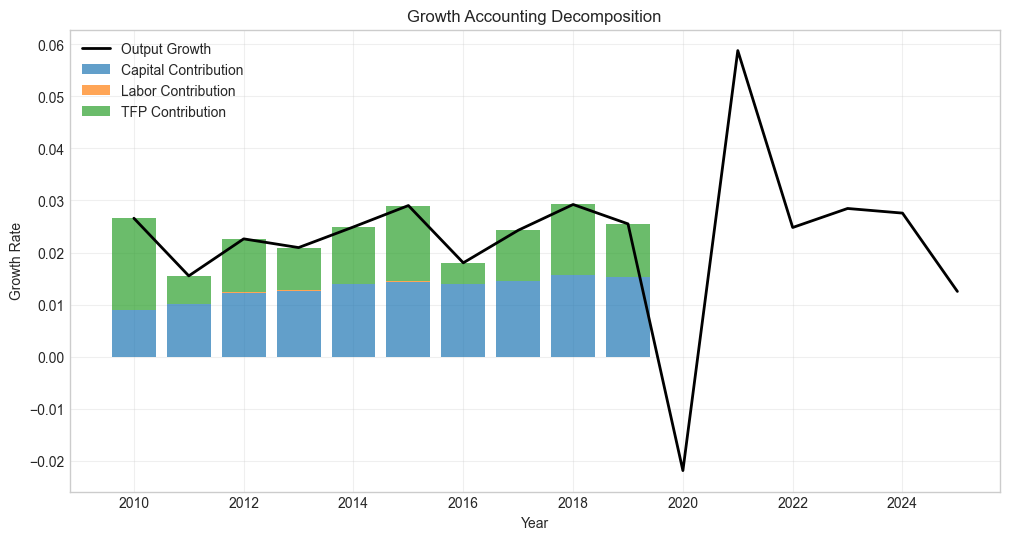

In [10]:
from fredapi import Fred
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class RealWorldGrowthAccountant:
    def __init__(self, api_key=None):
        """Initialize FRED API connection and setup data structures"""
        if api_key is None:
            api_key = os.getenv('FRED_API_KEY')
        if api_key is None:
            raise ValueError("FRED API key must be provided or set in FRED_API_KEY environment variable")
        
        self.fred = Fred(api_key=api_key)
        self.data = {}
        
    def fetch_series(self, series_id, start_date='1947-01-01'):
        """Fetch a series from FRED with error handling"""
        try:
            data = self.fred.get_series(series_id, observation_start=start_date)
            if data.empty:
                raise ValueError(f"No data found for series {series_id}")
            return data
        except Exception as e:
            raise ValueError(f"Error fetching series {series_id}: {str(e)}")
    
    def compute_growth_accounting(self, start_year=None, end_year=None):
        """
        Compute growth accounting decomposition using US data
        
        Parameters:
        -----------
        start_year : int, optional
            Starting year for analysis (default: earliest available)
        end_year : int, optional
            Ending year for analysis (default: latest available)
            
        Returns:
        --------
        DataFrame with decomposition results
        """
        try:
            # Fetch required series with updated series IDs
            self.data['gdp'] = self.fetch_series('GDPC1')  # Real GDP
            self.data['capital'] = self.fetch_series('RKNANPUSA666NRUG')  # Net Capital Stock
            self.data['labor'] = self.fetch_series('PAYEMS')  # Total Nonfarm Payrolls
            self.data['alpha'] = self.fetch_series('LABSHPUSA156NRUG')  # Labor Share
            
            # Convert labor share to capital share
            self.data['alpha'] = 1 - (self.data['alpha'] / 100)
            
            # Convert to annual frequency if needed
            for key in self.data:
                if isinstance(self.data[key], pd.Series):
                    self.data[key] = self.data[key].resample('YE').mean()  # Updated from 'A' to 'YE'
            
            # Compute growth rates
            df = pd.DataFrame({
                'g_Y': np.log(self.data['gdp']).diff(),
                'g_K': np.log(self.data['capital']).diff(),
                'g_L': np.log(self.data['labor']).diff(),
                'alpha': self.data['alpha']
            })
            
            # Filter dates if specified
            if start_year:
                df = df[df.index.year >= start_year]
            if end_year:
                df = df[df.index.year <= end_year]
            
            # Compute TFP growth (Solow residual)
            df['g_A'] = df['g_Y'] - (df['alpha'] * df['g_K']) - ((1 - df['alpha']) * df['g_L'])
            
            # Compute contributions
            df['capital_contrib'] = df['alpha'] * df['g_K']
            df['labor_contrib'] = (1 - df['alpha']) * df['g_L']
            df['tfp_contrib'] = df['g_A']
            
            return df
        
        except Exception as e:
            raise ValueError(f"Error in growth accounting computation: {str(e)}")
    
    def plot_decomposition(self, df=None, start_year=None, end_year=None):
        """
        Plot growth accounting decomposition
        
        Parameters:
        -----------
        df : DataFrame, optional
            Pre-computed decomposition (if None, will compute new)
        start_year, end_year : int, optional
            Time period for analysis
        """
        try:
            if df is None:
                df = self.compute_growth_accounting(start_year, end_year)
            
            # Create plot
            plt.figure(figsize=(12, 6))
            
            # Plot contributions
            plt.bar(df.index.year, df['capital_contrib'], 
                   label='Capital Contribution', alpha=0.7)
            plt.bar(df.index.year, df['labor_contrib'], bottom=df['capital_contrib'],
                   label='Labor Contribution', alpha=0.7)
            plt.bar(df.index.year, df['tfp_contrib'], 
                   bottom=df['capital_contrib'] + df['labor_contrib'],
                   label='TFP Contribution', alpha=0.7)
            
            # Plot total growth line
            plt.plot(df.index.year, df['g_Y'], 'k-', label='Output Growth', linewidth=2)
            
            plt.title('Growth Accounting Decomposition')
            plt.xlabel('Year')
            plt.ylabel('Growth Rate')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            return plt.gcf()
            
        except Exception as e:
            raise ValueError(f"Error in plotting decomposition: {str(e)}")

# Test the implementation with FRED data
try:
    # Initialize accountant (API key should be set in environment)
    accountant = RealWorldGrowthAccountant()
    
    # Compute decomposition for a recent period
    results = accountant.compute_growth_accounting(start_year=2010)
    
    # Display summary statistics
    print("\nGrowth Accounting Summary (2010-present):")
    print("----------------------------------------")
    print(f"Average Output Growth: {results['g_Y'].mean():.2%}")
    print(f"Average Capital Contribution: {results['capital_contrib'].mean():.2%}")
    print(f"Average Labor Contribution: {results['labor_contrib'].mean():.2%}")
    print(f"Average TFP Contribution: {results['tfp_contrib'].mean():.2%}")
    
    # Plot decomposition
    accountant.plot_decomposition(results)
    
except Exception as e:
    print(f"⚠️ **Analysis Error:** {str(e)}")